In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pydrake.all import MathematicalProgram, Variables, SolutionResult

In [3]:
# numeric parameters
m = 1.
l = 1.
g = 10.
b = .01

In [4]:
# optimization problem
nx = 3
prog = MathematicalProgram()
x = prog.NewIndeterminates(nx, 'x')

In [5]:
# dynamics in redundant coordinate system (with equilibrium x = 0)
# x = [sin(theta), cos(theta) - 1, d(theta)/dt]'
dynamics = np.array([
    (x[1] + 1.) * x[2], # d(sin(theta))/dt
    - x[0]*x[2], # d(cos(theta)-1)/dt
    - (b*x[2] + m*g*l*x[0]) / (m*l**2) # d2(theta)/dt2
])
constraint_set = x[0]**2 + x[1]**2 + x[1]

In [6]:
# Lyapunov function V - phi, with phi small PD function
V_degree = 2
eps = 0.1
V_psd, V_psd_constraint = prog.NewSosPolynomial(Variables(x), V_degree)
phi = eps * x.dot(x)
V = V_psd.ToExpression() + phi

In [7]:
# Lagrange multipliers for S-procedure
lam_degree = 2
lam = prog.NewFreePolynomial(Variables(x), lam_degree)

In [8]:
# time derivative of the Lyapunov function
Vdot = V.Jacobian(x).dot(dynamics)
prog.AddSosConstraint(- Vdot + lam.ToExpression() * constraint_set)

(<pydrake.solvers._mathematicalprogram_py.Binding_PositiveSemidefiniteConstraint at 0x7f0e8ae5adf0>,
 <pydrake.solvers._mathematicalprogram_py.Binding_LinearEqualityConstraint at 0x7f0e8ae5adb0>)

In [9]:
# solve feasibility SDP
result = prog.Solve()
assert(result == SolutionResult.kSolutionFound)

In [10]:
# retrieve Lyapunov function
V_coef = prog.GetSolution(V_psd_constraint.variables())
V_opt = V.Jacobian(V_psd_constraint.variables()).dot(V_coef) # since V is linear in the entries of the SOS matrix

In [11]:
# lyapunov level sets
def V_evaluate(theta, theta_dot):
    return V_opt.Evaluate({x[0]: np.sin(theta), x[1]: np.cos(theta) - 1., x[2]: theta_dot})

# total energy level sets
def total_energy(theta, theta_dot):
    kinetic = .5 * (m*l**2) * theta_dot**2
    potential = m * g * l * (1. - np.cos(theta))
    return kinetic + potential

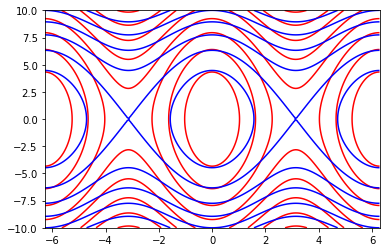

In [14]:
t = np.linspace(-2. * np.pi, 2. * np.pi, 200)
td = np.linspace(-10., 10., 200)
T, Td = np.meshgrid(t, td)
V = np.array([V_evaluate(t, td) for t, td in zip(np.ravel(T), np.ravel(Td))]).reshape(T.shape)
E = np.array([total_energy(t, td) for t, td in zip(np.ravel(T), np.ravel(Td))]).reshape(T.shape)
plt.contour(T, Td, V, colors='r')
plt.contour(T, Td, E, colors='b')
plt.show()